# AWS Inference Pipeline for Anomaly Detection

In this notebook, we will be building an [AWS Inference Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html) for detecting anomalies in time series data with applications in IoT. To get acquainted with the utility of the inference pipeline, I would encourage you to browse through [this blog post](https://aws.amazon.com/blogs/machine-learning/ensure-consistency-in-data-processing-code-between-training-and-inference-in-amazon-sagemaker/), which provides a high level-overview and a host of great examples.

### Helpful Resources:
* [Example RCF notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb)
* [How to use scikit container in inference pipeline](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_inference_pipeline/Inference%20Pipeline%20with%20Scikit-learn%20and%20Linear%20Learner.ipynb)
    * [more details on how to use/pass hyperparameters into scikit script for container in inference pipeline](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-adds-scikit-learn-support/)
    
### Note:
This [`Random Cut Forest`](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) approach to anomaly detection is advantageous for a couple reasons. First, it is unsupervised, so we have no need for labeled anomalous data for training. In fact, the algorithm would probably work best if training on what would be considered perfectly normal data.
Additionally, the algorithm just spits out an anomaly score, which we can think of as a value representing how different that data point is from what's expected. The greater the anomaly score, the more "anomalous" the data point is (read more [here](https://docs.aws.amazon.com/sagemaker/latest/dg/rcf_how-it-works.html)). In this notebook, we choose a threshold of 3 standard deviations as the anomaly threshold, but in reality, this would probably be determined with context. In short, the Random Cut Forest allows us room to make alterations based on the context of the problem.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting matplotlib style
plt.style.use(['seaborn-darkgrid', 'bmh'])
# construct cmap
my_cmap = ListedColormap(sns.color_palette("coolwarm").as_hex())

import boto3
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions

In [70]:
# Defining s3 bucket keys
bucket = 'datascience-anomaly'
raw_data = 'data/raw'
processed_data = 'data/processed'
preprocessor_output = 'models/preprocessor'
RCF_output = 'models/RCF/1.0-cjp-RCF'

# Defining s3 bucket output locations
raw_data_location = 's3://{}/{}'.format(bucket, raw_data)
processed_data_location = 's3://{}/{}'.format(bucket, processed_data)
preprocessor_output_location = 's3://{}/{}'.format(bucket, preprocessor_output)
RCF_output_location = 's3://{}/{}'.format(bucket, RCF_output)

In [71]:
print(raw_data_location)
print(processed_data_location)
print(preprocessor_output_location)
print(RCF_output_location)

s3://datascience-anomaly/data/raw
s3://datascience-anomaly/data/processed
s3://datascience-anomaly/models/preprocessor
s3://datascience-anomaly/models/RCF/1.0-cjp-RCF


# Importing raw data

The dataset that we will be using comes from [Kaggle's Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab/home). Specifically, we'll be working with the `realKnownCause/machine_temperature_system_failure.csv` dataset. I've uploaded this raw data to an s3 bucket that we will now pull the data from and into this notebook. For all intensive purposes, this is the ideal scenario, to have our training data in `csv` format in an s3 bucket. In fact, in this case, our pre-processing container requires that the data be in `csv` format.

In [72]:
machine_temp = pd.read_csv(raw_data_location + '/machine_temperature_system_failure.csv', index_col = 0, parse_dates = True, header = None)


In [73]:
# sampled every 5 mins
machine_temp.head()

,1
0,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


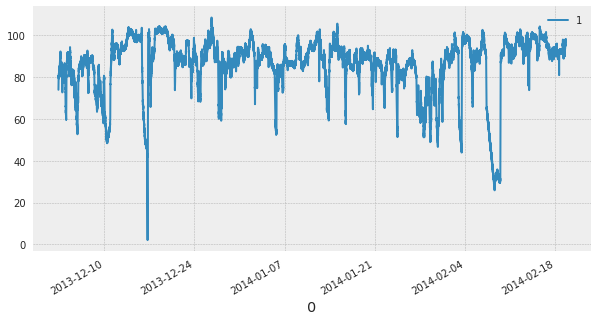

In [78]:
machine_temp.plot(figsize=(10,5))

# Pre-processing data

Here, we just [standardize the data](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) (get it all on the same scale), and implement a one-step pre-processing pipeline (this is the simplest type of use-case) but you may very well need to add more steps to this pre-processing pipeline when we have multiple features, and particularly when we also have categorical features.

## Creating Sagemaker Scikit Estimator (Transformer)

Here, we will be making use of the `sklearn_preprocessor.py` script in our current directory. [This example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_inference_pipeline/Inference%20Pipeline%20with%20Scikit-learn%20and%20Linear%20Learner.ipynb) explains some of AWS' requirements for this script in order for it to be used to build an SKLearn pre-processing container. After our pre-processpr is trained, the model artifacts will be saved at `preprocessor_output_location = "s3://datascience-anomaly/models/preprocessor"`.

### Helpful resources
* Here is the [readme](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn) to help build the SKLearn container.
* Here is the [readme](https://github.com/aws/sagemaker-containers) to help understand how `sagemaker-containers` connect and for help specifically with environment variables.

In [21]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'sklearn_preprocessor.py'

sklearn_preprocessor = SKLearn(
    entry_point = script_path,
    output_path = preprocessor_output_location,
    role = sagemaker.get_execution_role(),
    train_instance_type = "ml.m5.large",
    sagemaker_session = sagemaker.Session())

### Note:

In order to feed data into this preprocessor to "train" it, we need to specify the training data very specifically. We have three possible options, as listed below. 
 
* inputs: The S3 location(s) of datasets to be used for training.
    * `str`: An S3 URI, for example s3://my-bucket/my-training-data, which indicates the dataset's location.
    * `dict[str, str]`: A dictionary mapping channel names to S3 locations, for example `{'train': 's3://my-bucket/my-training-data/train', 'test': 's3://my-bucket/my-training-data/test'}`
    * `sagemaker.session.s3_input`: channel configuration for S3 data sources that can provide additional information as well as the path to the training dataset. See the API docs for full details.
    
In this case, we choose option two, giving a dictionary that maps the `train` channel to its s3 location.

In [22]:
sklearn_preprocessor.fit({'train': raw_data_location})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-480257627582
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2019-02-26-21-35-13-100


2019-02-26 21:35:13 Starting - Starting the training job...
2019-02-26 21:35:14 Starting - Launching requested ML instances......
2019-02-26 21:36:24 Starting - Preparing the instances for training......
2019-02-26 21:37:40 Downloading - Downloading input data
2019-02-26 21:37:40 Training - Training image download completed. Training in progress.
2019-02-26 21:37:40 Uploading - Uploading generated training model
2019-02-26 21:37:40 Completed - Training job completed

2019-02-26 21:37:29,475 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-02-26 21:37:29,477 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-02-26 21:37:29,489 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-02-26 21:37:29,785 sagemaker-containers INFO     Module sklearn_preprocessor does not provide a setup.py. 
Generating setup.py
2019-02-26 21:37:29,786 sagemaker-containers INFO     Generating setup.cfg
2019-02-2

In [23]:
print('Training job name: {}'.format(sklearn_preprocessor.latest_training_job.job_name))

Training job name: sagemaker-scikit-learn-2019-02-26-21-35-13-100


## Batch transform our training data for initial training

Our Random Cut Forest model will need to be trained on pre-processed data, so now that we have a working pre-processing container, we are going to pre-process our entire training set and save it at `processed_data_location = "s3://datascience-anomaly/data/processed"`. 

In [24]:
# Define a SKLearn Transformer from the trained SKLearn Estimator for batch transformation
sklearn_transformer = sklearn_preprocessor.transformer(
    output_path = processed_data_location,
    instance_count=1, 
    instance_type='ml.m5.large',
    assemble_with = 'Line',
    accept = 'text/csv')

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2019-02-26-21-35-13-100


In [25]:
# Preprocess training input
sklearn_transformer.transform(raw_data_location, content_type='text/csv')
print('Waiting for transform job: ' + sklearn_transformer.latest_transform_job.job_name)
sklearn_transformer.wait()
processed_data_location = sklearn_transformer.output_path

INFO:sagemaker:Creating transform job with name: sagemaker-scikit-learn-2019-02-26-21-39-31-437


Waiting for transform job: sagemaker-scikit-learn-2019-02-26-21-39-31-437
.............................................!


In [26]:
print(processed_data_location)

s3://datascience-anomaly/data/processed


# Training RCF model

Now that we have our pre-processed training data, we will use it to train our RCF anomaly detection model. After training, the model artifacts will be saved at `RCF_output_location = "s3://datascience-anomaly/models/RCF/1.0-cjp-RCF"`.

In [27]:
containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = boto3.Session().region_name
container = containers[region_name]

session = sagemaker.Session()

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    output_path = RCF_output_location,
    train_instance_count = 1,
    train_instance_type = 'ml.m5.large',
    sagemaker_session = sagemaker.Session())

rcf.set_hyperparameters(
    num_samples_per_tree=200,
    num_trees = 100,
    feature_dim = 1)

s3_train_input = sagemaker.session.s3_input(
    s3_data = processed_data_location,
    distribution='ShardedByS3Key',
    content_type='text/csv;label_size=0') # https://stackoverflow.com/questions/49303648/sagemaker-clienterror-rows-1-5000-have-more-fields-than-expected-size-3


### Important notes:

1. The two most important parameters in this RCF are the `num_trees` and `num_samples_per_tree`. Increasing `num_trees` has the effect of reducing the noise observed in anomaly scores since the final score is the average of the scores reported by each tree. While the optimal value is application-dependent, AWS recommends using 100 trees to begin with as a balance between score noise and model complexity. Here, we take their advice. Also, inference time is proportional to the number of trees. In the [RCF docs](https://docs.aws.amazon.com/sagemaker/latest/dg/rcf_how-it-works.html), they recommend that `num_samples_per_tree` be set such that `1/num_samples_per_tree` approximates the ratio of anomalous data to normal data. So in our model, we are assuming that we are expecting anomalies once in every 200 datapoints, or approximately 0.5% of the time.

2. In this case, we are training our RCF model with csv data. Since we are dealing with 1-dimensional training data, and the RCF is a relatively simple model (when compared with deep neural nets), feeding csv data into our model is no problem. If we were dealing with an application where inference speed is absolutely crucial, or a more computationally intensive model, we may consider serializing the data into the `protobuf recordIO` format, which is a bit more efficient. [This](https://aws.amazon.com/blogs/machine-learning/build-multiclass-classifiers-with-amazon-sagemaker-linear-learner/) is really the only article I've seen that compares the different data types (particularly their explanation of the `record_set` method). [Here](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-preprocess-data-transform.html) is an example of how we would practically serialize the data.

3. Notice that we are training our RCF on a single `ml.m5.large` EC2 Instance. For our RCF, that is more than enough computing power, however, if we were dealing with a more complex model, we may consider exapnds to multiple or more powerful instances (possibly even GPU instances). 

In [28]:
rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-02-26-21-46-31-171


2019-02-26 21:46:31 Starting - Starting the training job...
2019-02-26 21:46:34 Starting - Launching requested ML instances......
2019-02-26 21:47:41 Starting - Preparing the instances for training...
2019-02-26 21:48:27 Downloading - Downloading input data
2019-02-26 21:48:27 Training - Downloading the training image.....
Docker entrypoint called with argument(s): train
[02/26/2019 21:49:07 INFO 140487990449984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[02/26/2019 21:49:07 INFO 140487990449984] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim

training completed, and model stored in specified output

In [29]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-02-26-21-46-31-171


# Setting up the inference pipeline

Now that we both our pre-processor and our RCF model trained, and have save their corresponding artifacts in s3, we can stitch together the two containers into a repeatable inference pipeline.

In [31]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

scikit_learn_inference_model = sklearn_preprocessor.create_model()
rcf_model = rcf.create_model()

model_name = 'inference-pipeline-' + timestamp_prefix
endpoint_name = 'inference-pipeline-ep-' + timestamp_prefix
sm_model = PipelineModel(
    name = model_name, 
    role = sagemaker.get_execution_role(), 
    models = [scikit_learn_inference_model, rcf_model])

In [32]:
sm_model.name

'inference-pipeline-2019-02-26-21-51-20'

## Deploying inference pipeline to endpoint

In [33]:
sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: inference-pipeline-2019-02-26-21-51-20
INFO:sagemaker:Creating endpoint with name inference-pipeline-ep-2019-02-26-21-51-20


----------------------------------------------------------------------------!

In [34]:
endpoint_name

'inference-pipeline-ep-2019-02-26-21-51-20'

### Note:

* Here, we've deployed our endpoint to a `ml.c4.xlarge` EC2 instance. Likely more than enough for this anomaly detector. For more computationally-intensive models, it'd be beneficial to consider complementing our endpoint with an [Elastic Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/ei.html) accelerator to dynamic apply GPU computing resources when necessary (for a fraction of the cost of an entire GPU instance).

In [35]:
# making a quick prediction
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
predictor = RealTimePredictor(
    endpoint = endpoint_name,
    sagemaker_session = sagemaker.Session(),
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_JSON)


In [42]:
payload_1 = '2013-12-02 21:15:00, 75'
payload_2 = '2013-12-02 21:15:05, 175'
print(predictor.predict(payload_1))
print(predictor.predict(payload_2))

b'{"scores":[{"score":0.90694374}]}'
b'{"scores":[{"score":5.4339456335}]}'


---

---

# Using inference pipeline for batch predicts in order to visualize results

In [43]:
print(raw_data_location)
print(processed_data_location)
print(preprocessor_output_location)
print(RCF_output_location)

s3://datascience-anomaly/data/raw
s3://datascience-anomaly/data/processed
s3://datascience-anomaly/models/preprocessor
s3://datascience-anomaly/models/RCF/1.0-cjp-RCF


In [44]:
inference_pipeline_predictions = 'predictions/1.1-cjp-SKLearn-RCF-pipeline'
inference_pipeline_predictions_location = 's3://{}/{}'.format(bucket, inference_pipeline_predictions)

In [45]:
transform_job = sagemaker.transformer.Transformer(
    model_name = sm_model.name,
    instance_count = 1,
    instance_type = 'ml.m5.large',
    strategy = 'SingleRecord',
    assemble_with = 'Line',
    output_path = inference_pipeline_predictions_location,
    base_transform_job_name = 'inference-pipeline-batch',
    sagemaker_session = sagemaker.Session(),
    accept = CONTENT_TYPE_CSV)

transform_job.transform(data = raw_data_location, 
                        content_type = CONTENT_TYPE_CSV)

print('Waiting for transform job: ' + transform_job.latest_transform_job.job_name)
transform_job.wait()
print('You can find predictions at:', transform_job.output_path)

INFO:sagemaker:Creating transform job with name: inference-pipeline-batch-2019-02-26-22-08-10-026


Waiting for transform job: inference-pipeline-batch-2019-02-26-22-08-10-026
..........................................!
You can find predictions at: s3://datascience-anomaly/predictions/1.1-cjp-SKLearn-RCF-pipeline


In [46]:
anomaly_scores = pd.read_csv(transform_job.output_path + '/machine_temperature_system_failure.csv.out')

In [27]:
anomaly_scores = pd.read_csv('s3://datascience-anomaly/predictions/1.1-cjp-SKLearn-RCF-pipeline' + '/machine_temperature_system_failure.csv.out')

In [28]:
anomaly_scores_parsed = pd.Series(anomaly_scores.iloc[:,0].str.replace('{"score":', '').str.replace('}', ''),
                                  dtype = np.float64)

anomaly_scores_parsed.index = machine_temp.drop(machine_temp.index[0]).index
anomaly_scores_parsed.head()
                                     

0
2013-12-02 21:20:00    0.904206
2013-12-02 21:25:00    0.889730
2013-12-02 21:30:00    0.832405
2013-12-02 21:35:00    0.793671
2013-12-02 21:40:00    0.825795
Name: {"score":0.8978304748}, dtype: float64

In [29]:
# Had to drop first row, since for some reason batch transform jobs expect a header
print(len(anomaly_scores_parsed) == len(machine_temp))
machine_temp_dropped = machine_temp.drop(machine_temp.index[0])
print(len(anomaly_scores_parsed) == len(machine_temp_dropped))

False
True


## Computing anomaly scores

In [30]:
values_with_scores = pd.concat([machine_temp_dropped, anomaly_scores_parsed], axis=1)
values_with_scores.columns = ['value', 'score']
values_with_scores.head()

,value,score
0,,
2013-12-02 21:20:00,74.935882,0.904206
2013-12-02 21:25:00,76.124162,0.889730
2013-12-02 21:30:00,78.140707,0.832405
2013-12-02 21:35:00,79.329836,0.793671
2013-12-02 21:40:00,78.710418,0.825795


In [31]:
# calculating anomalies, which we define as 3 sd away from mean
score_mean = values_with_scores.score.mean()
score_std = values_with_scores.score.std()

score_cutoff = score_mean + (2.5 * score_std) # 98.76
anomalies = values_with_scores[values_with_scores['score'] > score_cutoff]

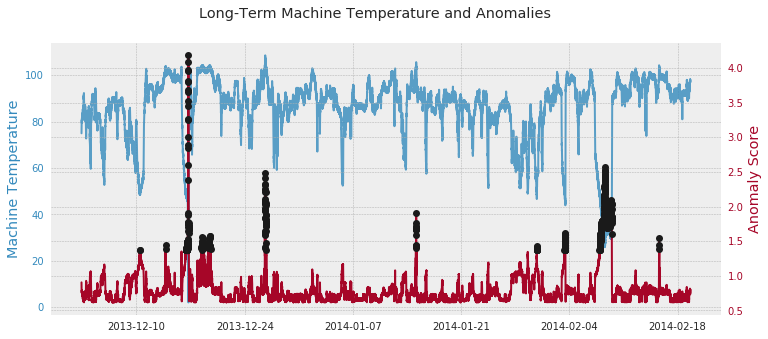

In [77]:
fig, ax1 = plt.subplots(figsize = (12,5))
ax2 = ax1.twinx()

ax1.plot(values_with_scores['value'], alpha=0.8)
ax1.set_ylabel('Machine Temperature', color='C0')
ax1.tick_params('y', colors='C0')

ax2.plot(values_with_scores['score'], color='C1')
ax2.plot(anomalies.index, anomalies.score, 'ko')
ax2.set_ylabel('Anomaly Score', color='C1')
ax2.tick_params('y', colors='C1')

fig.suptitle('Long-Term Machine Temperature and Anomalies')
plt.show()

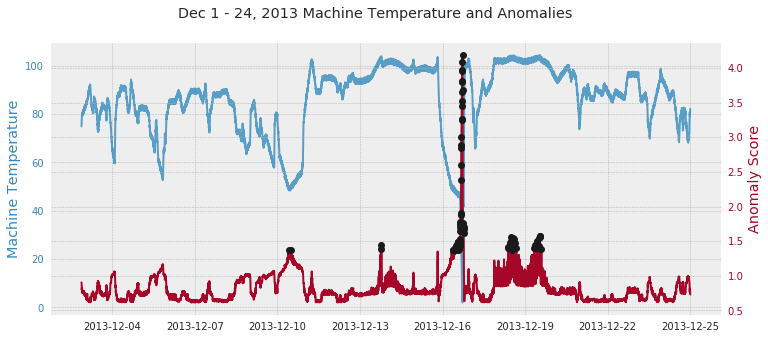

In [79]:
fig, ax1 = plt.subplots(figsize = (12,5))
ax2 = ax1.twinx()

ax1.plot(values_with_scores['12/01/2013': '12/24/2013']['value'], alpha=0.8)
ax1.set_ylabel('Machine Temperature', color='C0')
ax1.tick_params('y', colors='C0')

ax2.plot(values_with_scores['12/01/2013': '12/24/2013']['score'], color='C1')
ax2.plot(anomalies['12/01/2013': '12/24/2013'].index, anomalies['12/01/2013': '12/24/2013'].score, 'ko')
ax2.set_ylabel('Anomaly Score', color='C1')
ax2.tick_params('y', colors='C1')

fig.suptitle('Dec 1 - 24, 2013 Machine Temperature and Anomalies')
plt.show()

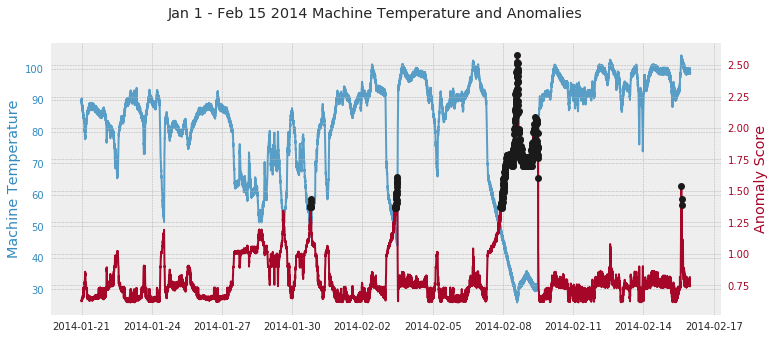

In [80]:
fig, ax1 = plt.subplots(figsize = (12,5))
ax2 = ax1.twinx()

ax1.plot(values_with_scores['1/21/2014': '2/15/2014']['value'], alpha=0.8)
ax1.set_ylabel('Machine Temperature', color='C0')
ax1.tick_params('y', colors='C0')

ax2.plot(values_with_scores['1/21/2014': '2/15/2014']['score'], color='C1')
ax2.plot(anomalies['1/21/2014': '2/15/2014'].index, anomalies['1/21/2014': '2/15/2014'].score, 'ko')
ax2.set_ylabel('Anomaly Score', color='C1')
ax2.tick_params('y', colors='C1')

fig.suptitle('Jan 1 - Feb 15 2014 Machine Temperature and Anomalies')
plt.show()

## Cleaning up and deleting endpoint

In [35]:
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

---

---

# Other various notes

## Biggest risks in pipeline (protecting scope of project)

As far as machine learning projects go, this anomaly detection pipeline definitely lands on the less-risky side of the spectrum, primarly because AWS' RCF is so flexible with respect to data types, and can be trained without anomalous data (we certainly cannot make these claims for all anomaly detectors). 

#### Documented assumptions:
1. There already is, or we can trivially collect lots of training data. I hesitate to given an exact number, since anomaly detecting varies so much from use-case to use-case, but I may conjecture that we'd like at least a few thousand examples to feel confident in our detector. In the example above, we have over 22,000 examples.
2. If we attempt to deploy this on the edge, there will certainly be overhead in determining the best way to deploy the model to our greengrass core and get that calibrated with their needs. (If not, this could lead to a low estimate)

## Making requests to deployed endpoint

As shown above, we can make real time predictions by invoking the deployed endpoint directly in this notebook, as well as make batch predictions on an entire dataset in s3. Typically, a client application will send requests directly to an API Gateway, which will then trigger a lambda function, which invokes the sagemaker endpoint to obtain inferences from a deployed model. [Here](https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/) is a practical example.

## Model maintenance

After training and deploying our initial model, it will be necessary to monitor its outputs. Ideally, we would have an industry expert working with the model to assess how to interpret the model's predictions, and to help us tune the threshold beyond which we declare to be anomalies. We can also take an analytical approach to monitoring the behavior of the model. It would be best practice to keep a record of all the predictions made by the model and aggregate statistics on these predictions. Assuming the machines continue to operate as normal, these statistics on our model's predictions should also stay the same (things like mean, median, standard deviation, etc). If, for instance, in a given week the distribution of the model's anomaly score outputs changes drastically, then that would indicate some problems. On the training data, the anomaly scores have an approximately [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) (see graph below). It would be concerning to see the model's outputs assume a normal distribution.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


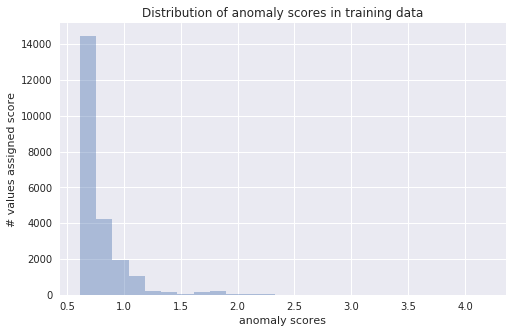

In [81]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})

# changing data format for faster graphing
x = np.array([values_with_scores.score])

# graphing distribution
ax = sns.distplot(x, bins=25, kde=False)
ax.set(xlabel='anomaly scores', ylabel='# values assigned score', title = 'Distribution of anomaly scores in training data')
plt.show()

## Transitioning to new model

If we decide to build a new model, the model's sagemaker endpoint configuration will be the tool we'll use to seamlessly introduce a new model to production, manage multiple models on the same endpoint, and the traffic that each model recieves. We can modify an endpoint without taking models that are already deployed into production out of service. For example, we can add new model variants, update the ML Compute instance configurations of existing model variants, or change the distribution of traffic among model variants. To modify an endpoint, you provide a new endpoint configuration - sagemaker implements the changes without any downtime.


One benefit of the inference pipeline is that when we create a new model, all of our previous pre-processing steps are preserved in their own containers, so that we need to iterate the model itself.

## Anomaly detection at the edge

In order to do anomaly detection at the edge, we would likely want to adopt AWS' [Greengrass](https://aws.amazon.com/greengrass/) technology to fully manage all of our computing resources. As a starting point, [this article](https://aws.amazon.com/blogs/iot/using-aws-iot-for-predictive-maintenance/) provides a high-level overview of all the technologies that may need to be involved in order to do edge inference well. The punch line is that we could run a lambda function that uses our ML model to make predictions. If we go down this route, we may also consider using [IoT Analytics](https://aws.amazon.com/iot-analytics/) to do our data pre-processing. We would need to weigh out the pros/cons of this approach juxtaposed with the approach we apply above, to include a pre-processing container in our inference pipeline itself. And if we're getting this deep into edge inferences, we may also be concerned with how well our ML models are performing on different types of hardware. It turns out that this can be a tricky thing to optimize, but that problem can be solved with [Sagemaker Neo](https://aws.amazon.com/sagemaker/neo/), which that enables machine learning models to be trained once and run anywhere in the cloud or at the edge with optimal performance. Without any manual intervention, Sagemaker Neo optimizes models deployed on EC2 instances, Sagemaker endpoints, and devices managed by AWS Greengrass.

In addition, we have the model artifacts for both the scikit-learn pre-processor and the Random Cut Forest model saved in s3 as `.tar.gz` files. It seems as though we could just unpack those and deploy those two models in tandem on mobile or embedded devices, however, AWS [says here](https://aws.amazon.com/aml/faqs/) that it is impossible.

## Kinesis for streaming anomaly detection

Unfortunately, sagemaker's RCF does not support anomaly detection on streaming data. For that, we must use [Kinesis' Data Analytics](https://docs.aws.amazon.com/kinesisanalytics/latest/dev/app-anomaly-detection.html) tools.

## Invoking endpoint from AWS cli

* Here is a [really helpful forum](https://forums.aws.amazon.com/thread.jspa?messageID=823468) on how to access the endpoint from the CLI
* [invoke-endpoint docs](https://docs.aws.amazon.com/sagemaker/latest/dg/API_runtime_InvokeEndpoint.html)
* [aws cli invoke-endpoint docs](https://docs.aws.amazon.com/cli/latest/reference/sagemaker-runtime/invoke-endpoint.html)